In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import f1_score

### Load Data From CSV File  

In [20]:
cell_df = pd.read_csv("bcd.csv")
cell_df.head()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


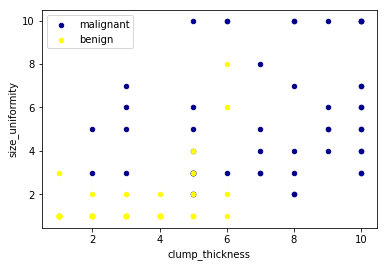

In [21]:
ax = cell_df[cell_df['class'] == 4][0:50].plot(kind='scatter', x='clump_thickness', y='size_uniformity', color='DarkBlue', label='malignant');
cell_df[cell_df['class'] == 2][0:50].plot(kind='scatter', x='clump_thickness', y='size_uniformity', color='Yellow', label='benign', ax=ax);
plt.show()

In [23]:
cell_df.dtypes

id                    int64
clump_thickness       int64
size_uniformity       int64
shape_uniformity      int64
marginal_adhesion     int64
epithelial_size       int64
bare_nucleoli        object
bland_chromatin       int64
normal_nucleoli       int64
mitoses               int64
class                 int64
dtype: object

It looks like the __bare_nucleoli__ column includes some values that are not numerical. We can drop those rows:

In [36]:
cell_df['bare_nucleoli'].fillna(0,inplace=True)
cell_df.dtypes

id                   int64
clump_thickness      int64
size_uniformity      int64
shape_uniformity     int64
marginal_adhesion    int64
epithelial_size      int64
bare_nucleoli        int32
bland_chromatin      int64
normal_nucleoli      int64
mitoses              int64
class                int32
dtype: object

In [37]:
feature_df = cell_df[['clump_thickness', 'size_uniformity', 'shape_uniformity', 'marginal_adhesion', 'epithelial_size' , 'bare_nucleoli', 'bland_chromatin', 'normal_nucleoli', 'mitoses']]

X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [38]:

cell_df['class'] = cell_df['class'].astype('int')
y = np.asarray(cell_df['class'])
y [0:5]

array([2, 2, 2, 2, 2])

## Train/Test dataset

Okay, we split our dataset into train and test set:

In [39]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<h2 id="modeling">Modeling (SVM with Scikit-learn)</h2>

In [40]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

C:\Users\Acer\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

After being fitted, the model can then be used to predict new values:

In [41]:
yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

<h2 id="evaluation">Evaluation</h2>

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

   micro avg       0.96      0.96      0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


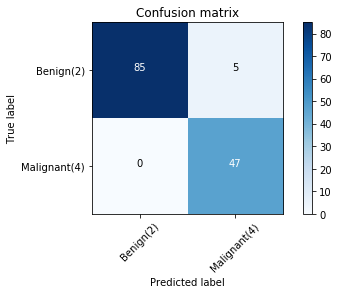

In [44]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

You can also easily use the __f1_score__ from sklearn library:

In [45]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9639038982104676

Lets try jaccard index for accuracy:

In [46]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.9635036496350365

In [47]:
k=0
j=0
max=0
for i in range(-100,100):
    clf2 = svm.SVC(kernel='poly',probability=True,gamma=0.05,degree=7,decision_function_shape='ovo',coef0=i/100)
    clf2.fit(X_train, y_train) 
    yhat2 = clf2.predict(X_test)
    k= f1_score(y_test, yhat2, average='weighted')
    if(k>max):
        max,j=k,i 
    i=i+1
print(max)
print(j)

0.9782552410493706
-7
